[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/15_missing_data_and_other_opportunities.ipynb)

# 15. Missing Data and Other Opportunities

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  %pip install -q watermark
  %pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization
import matplotlib.pyplot as plt

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior


# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root


In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,rethinking

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
rethinking            : 0.1.0



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

##### Code 15.1

In [6]:
# simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = tfd.Categorical(logits=np.ones(3)).sample().numpy()
    sides = np.array([1, 1, 1, 0, 0, 0]).reshape(3, 2).T[:, pancake]
    np.random.shuffle(sides)
    return sides


# sim 10,000 pancakes
pancakes = []
for i in range(10_000):
    pancakes.append(sim_pancake())

pancakes = np.array(pancakes).T

up = pancakes[0]
down = pancakes[1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
num_11 / num_11_10


0.6525812238389476

## 15.1 Measurement error

##### Code 15.2

In the waffle dataset, both divorce rate and marriage rate variables are measured with substantial error and that error is reported in the form of standard errors.

Also error varies across the states. 

Below we are plotting the measurement errors

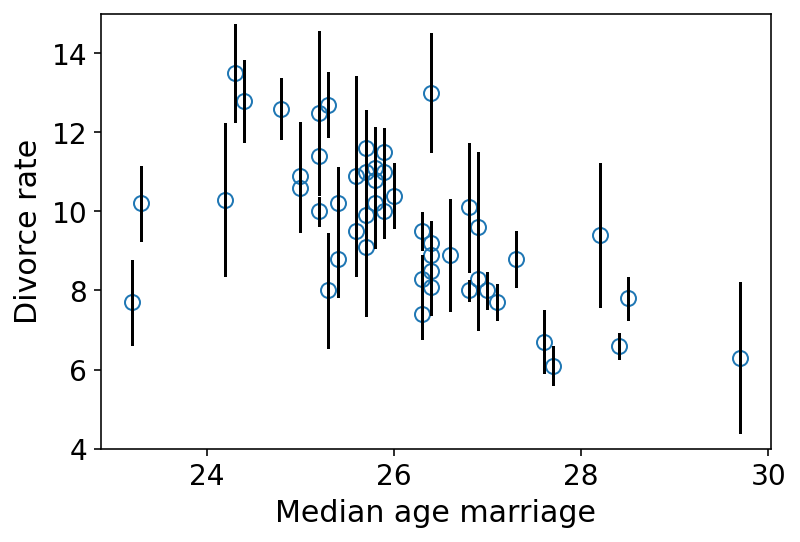

In [7]:
d = RethinkingDataset.WaffleDivorce.get_dataset()

# points
ax = az.plot_pair(
    d[["MedianAgeMarriage", "Divorce"]].to_dict(orient="list"),
    scatter_kwargs=dict(ms=15, mfc="none"),
)
ax.set(ylim=(4, 15), xlabel="Median age marriage", ylabel="Divorce rate")

# standard errors
for i in range(d.shape[0]):
    ci = d.Divorce[i] + np.array([-1, 1]) * d["Divorce SE"][i]
    x = d.MedianAgeMarriage[i]
    plt.plot([x, x], ci, "k")


In the above plot, the lenght of the vertical lines show how uncertain the observed divorce rate is.

### 15.1.1 Error on the outcome

##### Code 15.3

In [8]:
d["D_obs"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values
d["D_sd"] = d["Divorce SE"].values / d.Divorce.std()
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values

N = d.shape[0]

tdf = dataframe_to_tensors("Waffle", d, ["D_obs", "D_sd", "M", "A"])


def model_15_1(A, M, D_sd, N):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaA = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaA"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )

        mu = (
            alpha[..., tf.newaxis]
            + betaA[..., tf.newaxis] * A
            + betaM[..., tf.newaxis] * M
        )

        scale = sigma[..., tf.newaxis]

        D_true = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1
        )
        D_obs = yield tfd.Independent(
            tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_15_1 = model_15_1(tdf.A, tdf.M, tdf.D_sd, N)


In [9]:
NUM_CHAINS_FOR_15_1 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1]),
    tf.ones([NUM_CHAINS_FOR_15_1]),
    tf.zeros([NUM_CHAINS_FOR_15_1, N]),
]

bijectors = [tfb.Identity(), tfb.Identity(), tfb.Identity(), tfb.Exp(), tfb.Identity()]

posterior_15_1, trace_15_1 = sample_posterior(
    jdc_15_1,
    observed_data=(tdf.D_obs,),
    params=["alpha", "betaA", "betaM", "sigma", "D_true"],
    init_state=init_state,
    bijectors=bijectors,
)


##### Code 15.4

In [10]:
az.summary(trace_15_1, round_to=2, kind="all", hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.07,0.10,-0.22,0.09,0.01,0.01,103.83,184.40,1.00
betaA,-0.63,0.17,-0.89,-0.36,0.03,0.02,43.58,116.75,1.04
betaM,0.06,0.17,-0.20,0.32,0.03,0.02,44.04,104.82,1.05
sigma,0.59,0.10,0.45,0.75,0.01,0.01,82.66,146.30,1.01
D_true[0],1.18,0.37,0.64,1.75,0.03,0.02,132.33,217.49,1.01
D_true[1],0.63,0.52,-0.25,1.35,0.07,0.05,63.37,134.96,1.02
D_true[2],0.44,0.33,-0.08,0.92,0.02,0.02,234.45,309.39,1.00
D_true[3],1.43,0.48,0.74,2.17,0.05,0.03,108.94,209.20,1.01
D_true[4],-0.91,0.12,-1.08,-0.72,0.00,0.00,896.46,182.82,1.01
D_true[5],0.69,0.43,-0.03,1.31,0.04,0.03,111.54,132.18,1.02


##### Code 15.5

What happens when there is a measurement error on predictor variables as well ?

In [11]:
d["D_obs"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values
d["D_sd"] = d["Divorce SE"].values / d.Divorce.std()
d["M_obs"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values
d["M_sd"] = d["Marriage SE"].values / d.Marriage.std()
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values

N = d.shape[0]

tdf = dataframe_to_tensors("Waffle", d, ["D_obs", "D_sd", "M_obs", "M_sd", "A"])


def model_15_2(A, M_sd, D_sd, N):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.2, name="alpha"), sample_shape=1)
        )
        betaA = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaA"), sample_shape=1)
        )
        betaM = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaM"), sample_shape=1)
        )
        sigma = yield Root(
            tfd.Sample(tfd.Exponential(rate=1.0, name="sigma"), sample_shape=1)
        )
        M_true = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=1.0, name="M_true"), sample_shape=N)
        )

        mu = (
            alpha[..., tf.newaxis]
            + betaA[..., tf.newaxis] * A
            + betaM[..., tf.newaxis] * M_true
        )

        scale = sigma[..., tf.newaxis]

        D_true = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1
        )
        D_obs = yield tfd.Independent(
            tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1
        )
        M_obs = yield tfd.Independent(
            tfd.Normal(loc=M_true, scale=M_sd, name="M_obs"),
            reinterpreted_batch_ndims=1,
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_15_2 = model_15_2(tdf.A, tdf.M_sd, tdf.D_sd, N)


In [12]:
NUM_CHAINS_FOR_15_2 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2]),
    tf.ones([NUM_CHAINS_FOR_15_2]),
    tf.zeros([NUM_CHAINS_FOR_15_2, N]),  # M_True
    tf.zeros([NUM_CHAINS_FOR_15_2, N]),  # D_True
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
]

posterior_15_2, trace_15_2 = sample_posterior(
    jdc_15_2,
    observed_data=(tdf.D_obs, tdf.M_obs),
    params=["alpha", "betaA", "betaM", "sigma", "M_true", "D_true"],
    init_state=init_state,
    bijectors=bijectors,
)


##### Code 15.6

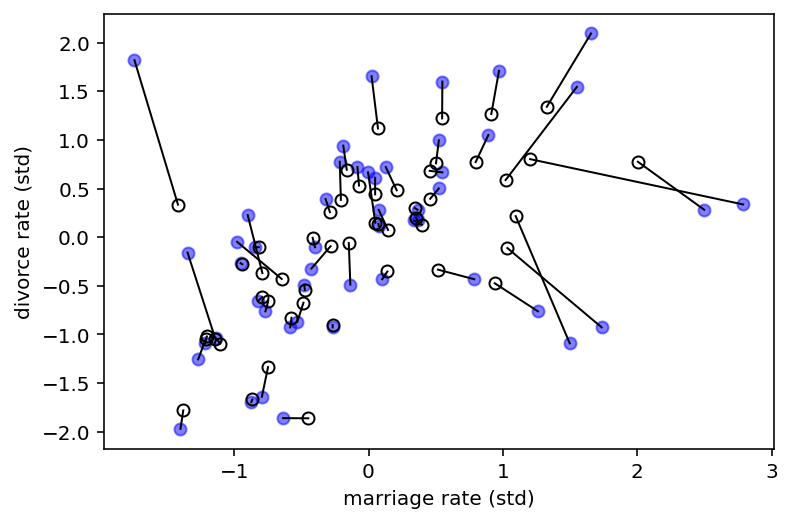

In [13]:
post_D_true = trace_15_2.posterior["D_true"].values[0]
post_M_true = trace_15_2.posterior["M_true"].values[0]

D_est = np.mean(post_D_true, 0)
M_est = np.mean(post_M_true, 0)
plt.plot(d["M_obs"], d["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(d.shape[0]):
    plt.plot([d["M_obs"][i], M_est[i]], [d["D_obs"][i], D_est[i]], "k-", lw=1)


Above figure demonstrates shrinkage of both divorce rate and marriage rate. Solid points are the observed values. Open points are posterior means. Lines connect pairs of points for the same state. Both variables are shrunk towards the inferred regression relationship.

With measurement error, the insight is to realize that any uncertain piece of data can be replaced by a distribution that reflects uncertainty.

##### Code 15.7

In [14]:
# Simulated toy data

N = 500
A = tfd.Normal(loc=0.0, scale=1.0).sample((N,))
M = tfd.Normal(loc=-A, scale=1.0).sample()
D = tfd.Normal(loc=A, scale=1.0).sample()
A_obs = tfd.Normal(loc=A, scale=1.0).sample()


## 15.2 Missing data

### 15.2.1 DAG ate my homework

##### Code 15.8

In [15]:
N = 100
S = tfd.Normal(loc=0.0, scale=1.0).sample((N,))
H = tfd.Binomial(total_count=10, probs=tf.sigmoid(S)).sample()


##### Code 15.9

Hm = Homework missing

Dog's decision to eat a piece of homework or not is not influenced by any relevant variable

In [16]:
D = tfd.Bernoulli(0.5).sample().numpy()  # dogs completely random
Hm = np.where(D == 1, np.nan, H)

Hm


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

Since missing values are random, missignness does not necessiarily change the overall distribution of homework score.

##### Code 15.10

Here studying influences whether a dog eats homework S->D

Students who study a lot do not play with their Dogs and then dogs take revenge by eating homework


In [17]:
D = np.where(S > 0, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm


array([ 5.,  4.,  4.,  0., nan,  2.,  3., nan, nan, nan, nan, nan, nan,
        5.,  3.,  3., nan, nan, nan,  0.,  0., nan,  2., nan,  7.,  3.,
        2.,  5., nan, nan, nan,  0.,  4., nan,  2., nan, nan, nan,  2.,
        7.,  1.,  2.,  0.,  4.,  2., nan, nan, nan, nan,  6., nan, nan,
       nan, nan, nan,  1.,  4., nan, nan,  5.,  6.,  4., nan,  1., nan,
        2.,  5.,  1., nan,  4.,  8., nan, nan,  0.,  0.,  2.,  4., nan,
       nan, nan, nan, nan,  6., nan,  2.,  3., nan,  2., nan, nan, nan,
        4.,  2.,  3., nan,  3.,  5.,  5., nan, nan], dtype=float32)

Now every student who studies more than average (0) is missing homework

##### Code 15.11

The case of noisy home and its influence on homework & Dog's behavior

In [18]:
# TODO - use seed; have not been able to make it work with tfp

N = 1000
X = tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=(N,)).sample().numpy()
S = tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=(N,)).sample().numpy()

logits = 2 + S - 2 * X

H = tfd.Binomial(total_count=10, logits=logits).sample().numpy()

D = np.where(X > 1, 1, 0)
Hm = np.where(D == 1, np.nan, H)


##### Code 15.12

In [19]:
tdf = dataframe_to_tensors(
    "SimulatedHomeWork", pd.DataFrame.from_dict(dict(H=H, S=S)), ["H", "S"]
)


def model_15_3(S):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=1.0, name="alpha"), sample_shape=1)
        )
        betaS = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaS"), sample_shape=1)
        )

        logits = tf.squeeze(alpha[..., tf.newaxis] + betaS[..., tf.newaxis] * S)

        H = yield tfd.Independent(
            tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_15_3 = model_15_3(tdf.S)


In [20]:
NUM_CHAINS_FOR_15_3 = 4

alpha_init, betaS_init, _ = jdc_15_3.sample()

init_state = [
    tf.tile(alpha_init, (NUM_CHAINS_FOR_15_3,)),
    tf.tile(betaS_init, (NUM_CHAINS_FOR_15_3,)),
]


bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]

posterior_15_3, trace_15_3 = sample_posterior(
    jdc_15_3,
    observed_data=(tdf.H,),
    params=["alpha", "betaS"],
    init_state=init_state,
    bijectors=bijectors,
)


In [21]:
az.summary(trace_15_3, round_to=2, kind="all", hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.26,0.02,1.23,1.30,0.01,0.0,10.11,94.25,1.31
betaS,0.55,0.02,0.52,0.58,0.01,0.0,8.89,47.19,1.37


The true coefficient on S should be 1.00. We don’t expect to get that exactly, but the estimate above is way off

##### Code 15.13

We build the model with missing data now

In [22]:
tdf = dataframe_to_tensors(
    "SimulatedHomeWork",
    pd.DataFrame.from_dict(dict(H=H[D == 0], S=S[D == 0])),
    ["H", "S"],
)


def model_15_4(S):
    def _generator():
        alpha = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=1.0, name="alpha"), sample_shape=1)
        )
        betaS = yield Root(
            tfd.Sample(tfd.Normal(loc=0.0, scale=0.5, name="betaS"), sample_shape=1)
        )

        logits = tf.squeeze(alpha[..., tf.newaxis] + betaS[..., tf.newaxis] * S)

        H = yield tfd.Independent(
            tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)


jdc_15_4 = model_15_4(tdf.S)


In [23]:
NUM_CHAINS_FOR_15_4 = 2

alpha_init, betaS_init, _ = jdc_15_4.sample()

init_state = [
    tf.tile(alpha_init, (NUM_CHAINS_FOR_15_4,)),
    tf.tile(betaS_init, (NUM_CHAINS_FOR_15_4,)),
]

bijectors = [
    tfb.Identity(),
    tfb.Identity(),
]

posterior_15_4, trace_15_4 = sample_posterior(
    jdc_15_4,
    observed_data=(tdf.H,),
    params=["alpha", "betaS"],
    init_state=init_state,
    bijectors=bijectors,
)


In [24]:
az.summary(trace_15_4, round_to=2, kind="all", hdi_prob=0.89)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.90,0.04,1.84,1.96,0.0,0.0,823.14,450.37,1.0
betaS,0.81,0.04,0.75,0.86,0.0,0.0,833.64,433.39,1.0


##### Code 15.14

In [25]:
D = np.where(np.abs(X) < 1, 1, 0)


##### Code 15.15

In [26]:
N = 100
S = tfd.Normal(loc=0.0, scale=1.0).sample((N,))
H = tfd.Binomial(total_count=10, logits=S).sample().numpy()
D = np.where(H < 5, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm


array([ 8.,  7.,  5.,  8.,  8.,  6.,  6.,  9.,  7.,  8.,  7., nan, nan,
       nan,  7.,  6.,  5.,  8.,  6.,  9., nan,  7.,  7.,  7.,  7.,  6.,
       nan,  7.,  8.,  7.,  5., nan,  5., nan,  5., nan,  6.,  5.,  6.,
       nan, 10., nan, nan,  7., nan,  6., nan,  9.,  7., nan,  5., nan,
       nan, nan,  5., nan, nan,  9., nan, nan,  8.,  5., nan, nan,  8.,
        9., nan,  6., nan,  7., nan,  9., nan,  7.,  7.,  5.,  5.,  7.,
       nan, nan,  5., nan,  9., 10., nan,  6., nan, nan,  8., nan,  5.,
        6., nan,  6.,  8., nan, nan,  7.,  5.,  5.], dtype=float32)

## 15.3 Categorical errors and discrete absences (TODO)